In [2]:
import os
import gc
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
from google.cloud import storage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.getcwd())+'/src')
from guara.modeling.supervised_modelz import SupervisedModelz

In [29]:
metrics_df = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1', 'ROC_AUC', 'features'])
metrics_df

,Accuracy,Recall,Precision,F1,ROC_AUC,features


### Reading input data

In [4]:
df_train = pd.read_parquet('gs://gpa-churn/data/processed/train/dataset.parquet')
df_val = pd.read_parquet('gs://gpa-churn/data/processed/validation/dataset.parquet')

target = 'target'
features = list(df_train.columns)
features = [i for i in features if i!=target]

xtrain = df_train[features]
xval = df_val[features]
ytrain = df_train[target]
yval = df_val[target]
print(xtrain.shape, ytrain.shape, '/', xval.shape, yval.shape)

(726090, 52) (726090,) / (128134, 52) (128134,)


In [5]:
xval.isna().sum()

val_venda_bruta_cupom            0
qtd_item_venda                   0
flg_vend_meu_desct               0
valor_desconto                   0
tipo_promo_0                     0
tipo_promo_1                     0
tipo_promo_2                     0
tipo_promo_3                     0
tipo_promo_4                     0
tipo_promo_5                     0
categoria_0                      0
categoria_1                      0
categoria_2                      0
categoria_3                      0
categoria_4                      0
categoria_5                      0
categoria_6                      0
categoria_7                      0
departamento_0                   0
compras_mes                      0
agg_l3m_val_venda_bruta_cupom    0
agg_l3m_qtd_item_venda           0
agg_l3m_flg_vend_meu_desct       0
agg_l3m_valor_desconto           0
agg_l3m_tipo_promo_0             0
agg_l3m_tipo_promo_1             0
agg_l3m_tipo_promo_2             0
agg_l3m_tipo_promo_3             0
agg_l3m_tipo_promo_4

In [9]:
df_train_0 = df_train[df_train[target]==0]
df_train_1 = df_train[df_train[target]==1]

In [209]:
features = ['val_venda_bruta_cupom', 'qtd_item_venda', 'compras_mes', 'sexo', 'pib_percapita', 'idade', 'delta_de_cadastro', 'ind_email', 'cadastro_stix', 'delta_de_stix', 'agg_l3m_val_venda_bruta_cupom', 'agg_l3m_qtd_item_venda', 'agg_l3m_valor_desconto', 'agg_l3m_compras_mes']

In [210]:
#for var in features:
#     sn.distplot(df_train_0[var], hist=False, rug=True, color='green', label='0')
#     sn.distplot(df_train_1[var], hist=False, rug=True, color='red', label='1')
#    plt.legend()
#     plt.show()

### Testing subsets

In [211]:
md = SupervisedModelz('lgbm', 'binary')

In [212]:
params = {

    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu', # 'cpu'
    'is_unbalanced':'true',
    #'metric': 'huber',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': -1,
    'n_estimators': 2000,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
    
 }

model = md.fit(xtrain[features], xval[features], ytrain, yval, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample


Found `n_estimators` in params. Will use it instead of argument
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 73810, number of negative: 652280
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 726090, number of used features: 14
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101654 -> initscore=-2.178980
[LightGBM] [Info] Start training from score -2.178980
Modelo treinado em 0.75 minutos 



`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


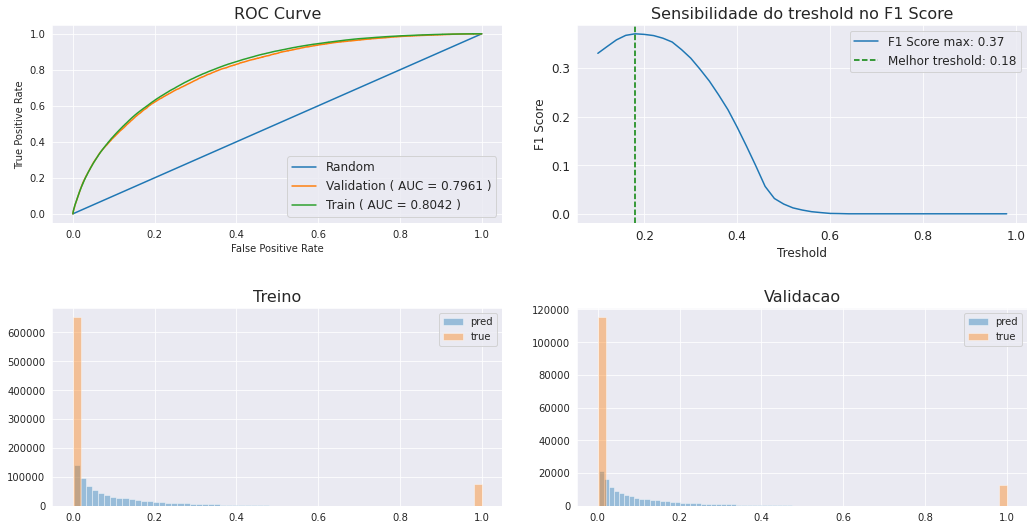

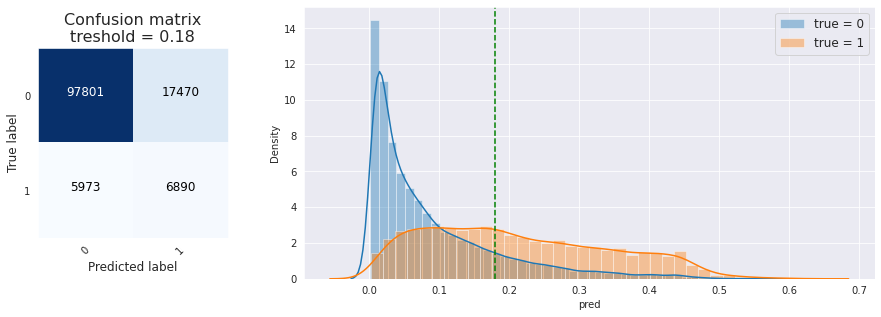


              precision    recall  f1-score   support

           0       0.94      0.85      0.89    115271
           1       0.28      0.54      0.37     12863

    accuracy                           0.82    128134
   macro avg       0.61      0.69      0.63    128134
weighted avg       0.88      0.82      0.84    128134



In [213]:
ytrain_pred = md.predict(xtrain[features])
yval_pred = md.predict(xval[features])

md.evaluation_plots(ytrain.values, ytrain_pred, yval.values, yval_pred)

In [214]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1', 'ROC_AUC']

print('TREINO:\n')
metrics_train = md.metrics_print(ytrain.values, ytrain_pred.clip(0, None), metrics)
print('\nVALIDACAO:\n')
metrics_val = md.metrics_print(yval.values, yval_pred.clip(0, None), metrics)

TREINO:

|   Accuracy |   Recall |   Precision |     F1 |   ROC_AUC |
|------------|----------|-------------|--------|-----------|
|     0.8183 |   0.5466 |      0.2907 | 0.3795 |    0.6978 |

VALIDACAO:

|   Accuracy |   Recall |   Precision |     F1 |   ROC_AUC |
|------------|----------|-------------|--------|-----------|
|     0.8170 |   0.5356 |      0.2828 | 0.3702 |    0.6920 |


In [215]:
metrics_val

,Accuracy,Recall,Precision,F1,ROC_AUC
,0.817043,0.535645,0.282841,0.370201,0.692044


### Metrics

In [218]:
metrics_val['features'] = str(features)
metrics_val

,Accuracy,Recall,Precision,F1,ROC_AUC,features
,0.817043,0.535645,0.282841,0.370201,0.692044,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."


In [219]:
metrics_df = pd.concat([metrics_df, metrics_val])
metrics_df

,Accuracy,Recall,Precision,F1,ROC_AUC,features
,0.778958,0.509912,0.229512,0.316546,0.659446,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.778958,0.509912,0.229512,0.316546,0.659446,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817145,0.518619,0.279016,0.362830,0.684538,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817129,0.535023,0.282826,0.370040,0.691816,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.769686,0.548317,0.229336,0.323406,0.671353,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.796073,0.500117,0.246164,0.329931,0.664607,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817426,0.536500,0.283607,0.371061,0.692637,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817644,0.535101,0.283613,0.370731,0.692137,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817176,0.535178,0.282931,0.370167,0.691911,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817465,0.533157,0.282897,0.369654,0.691174,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."


In [220]:
metrics_df.drop_duplicates()

,Accuracy,Recall,Precision,F1,ROC_AUC,features
,0.778958,0.509912,0.229512,0.316546,0.659446,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817145,0.518619,0.279016,0.362830,0.684538,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817129,0.535023,0.282826,0.370040,0.691816,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.769686,0.548317,0.229336,0.323406,0.671353,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.796073,0.500117,0.246164,0.329931,0.664607,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817426,0.536500,0.283607,0.371061,0.692637,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817644,0.535101,0.283613,0.370731,0.692137,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817176,0.535178,0.282931,0.370167,0.691911,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817465,0.533157,0.282897,0.369654,0.691174,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.816926,0.535256,0.282577,0.369883,0.691807,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."


In [243]:
metrics_df.to_parquet('gs://gpa-churn/data/reference/feature-sets.parquet', compression='gzip')

In [221]:
metrics_df['features'].iloc[6]

"['val_venda_bruta_cupom', 'qtd_item_venda', 'compras_mes', 'valor_desconto', 'agg_l3m_val_venda_bruta_cupom', 'agg_l3m_qtd_item_venda', 'agg_l3m_valor_desconto', 'agg_l3m_compras_mes', 'sexo', 'pib_percapita']"

In [230]:
metrics_df['features'].iloc[1]

"['val_venda_bruta_cupom', 'qtd_item_venda', 'compras_mes']"

In [225]:
metrics_df['features'].iloc[-1]

"['val_venda_bruta_cupom', 'qtd_item_venda', 'compras_mes', 'sexo', 'pib_percapita', 'idade', 'delta_de_cadastro', 'ind_email', 'cadastro_stix', 'delta_de_stix', 'agg_l3m_val_venda_bruta_cupom', 'agg_l3m_qtd_item_venda', 'agg_l3m_valor_desconto', 'agg_l3m_compras_mes']"

In [244]:
teste = pd.read_parquet('gs://gpa-churn/data/reference/feature-sets.parquet')
teste

,Accuracy,Recall,Precision,F1,ROC_AUC,features
,0.778958,0.509912,0.229512,0.316546,0.659446,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.778958,0.509912,0.229512,0.316546,0.659446,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817145,0.518619,0.279016,0.362830,0.684538,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817129,0.535023,0.282826,0.370040,0.691816,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.769686,0.548317,0.229336,0.323406,0.671353,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.796073,0.500117,0.246164,0.329931,0.664607,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817426,0.536500,0.283607,0.371061,0.692637,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817644,0.535101,0.283613,0.370731,0.692137,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817176,0.535178,0.282931,0.370167,0.691911,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
,0.817465,0.533157,0.282897,0.369654,0.691174,"['val_venda_bruta_cupom', 'qtd_item_venda', 'c..."
